# DSSS: Assessing London Housing Prices

I aim to answer the following research questions:

What are the main factors that influence property values in London according to a random forest model based on London census data?
How do property values vary across London opportunity areas and adjacent areas using a regression discontinuity design?
My main data source will be the 2021 census, which provides comprehensive data on London’s population characteristics such as age, sex, ethnicity, religion, education, occupation, income, housing tenure, and so on.

My outcome variable will be median property value per LSOA, from HMRC price paid data. The random forest technique will be applied to build a model for property value based on the independent variables. The regression discontinuity design will be applied to compare property values between opportunity areas (treatment group) and adjacent areas (control group) using distance from opportunity area boundary as the assignment variable. The assumption is that properties close to the boundary are similar in other aspects except for their location within or outside an opportunity area. The causal effect of being in an opportunity area on property value will be estimated by fitting local linear regressions on both sides of the boundary.



Introduction 

Literature review 

Research question 

Presentation of data 

## Data Importing

In [ ]:
pip install UKCensusAPI

In [ ]:
pip install skimpy

In [17]:
pip install unzip-http

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests, zipfile, io

# Define a list of the names of the boroughs
boroughs = ["Camden"]

# Download and read the zip file into a bytes buffer
zip_file_url = "https://data.london.gov.uk/download/house-price-per-square-metre-in-england-and-wales/540ec1b4-b04a-434a-9b2c-ab1977432c58/hpm_la_2022.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Create an empty list to store the dataframes
dfs = []

# Iterate over the files in the zip file
for file in z.namelist():
    # Check if the file name contains part of the string for any of the borough names
    if any(borough in file for borough in boroughs):
        # Read the file as a pandas dataframe
        df = pd.read_csv(z.open(file))
        # Append the dataframe to the list
        dfs.append(df)

# Print the list of dataframes
print(dfs)

In [21]:
import unzip_http

In [ ]:
url = 

In [3]:
import ukcensusapi.Nomisweb as census_api
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sn

from skimpy import clean_columns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error, r2_score

# preprocessors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# pipeline
from sklearn.pipeline import Pipeline

# linear regression
from sklearn.linear_model import LinearRegression

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# xgboost
import xgboost
from xgboost import XGBRegressor

Price paid to UPRN: http://ubdc.gla.ac.uk/dataset/price-paid-data-to-uprn-lookup/resource/119df18f-2eaf-4259-8a5a-13eafdab1377

OS Open UPRN: https://osdatahub.os.uk/downloads/open/OpenUPRN

House price square metre: https://data.london.gov.uk/dataset/house-price-per-square-metre-in-england-and-wales?resource=5313e02a-6f0c-4bca-8294-5be87a631160

In [57]:
help(urllib)

Help on package urllib:

NAME
    urllib

MODULE REFERENCE
    https://docs.python.org/3.10/library/urllib.html
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

PACKAGE CONTENTS
    error
    parse
    request
    response
    robotparser

FILE
    /opt/conda/lib/python3.10/urllib/__init__.py




In [ ]:
import geopandas as gpd

In [ ]:
openuprn = gpd.read_file("data/osopenuprn_202302.gpkg", rows = 5)
openuprn.head()

In [ ]:
openuprn.plot()

In [53]:
uprn = pd.read_csv("data/ppdiduprnusrnubdc.csv")
uprn.head()

,transactionid,uprn,usrn
0,{DD204FA6-B333-4A06-9E31-7ACABE162EB7},30,4549897
1,{B26F0F8D-4C7A-4DBF-B10A-3336830BF462},31,4549897
2,{241A4A53-DD8C-706B-E050-A8C06205638B},63,4582546
3,{85866A64-627D-143F-E053-6B04A8C06A15},97,4527985
4,{BE61D947-ED06-482E-8274-8B84912C15CB},103,4527985


<AxesSubplot:>

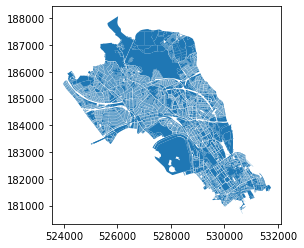

In [30]:
camden = gpd.read_file("data/Land_Registry_Cadastral_Parcels.gml")
camden.plot()

In [11]:
camden_price = pd.read_csv("data/hpm_la_2022/Camden_link_13082022.csv")
camden_price.head()

,priceper,year,dateoftransfer,propertytype,duration,price,postcode,lad21cd,transactionid,id,tfarea,numberrooms,classt,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,CONSTRUCTION_AGE_BAND
0,4453.125000,1999,1999-03-08,F,L,285000,EC1M 3HA,E09000007,{874382CA-FB65-4783-A7E9-4808A66E2193},19077801,64.0,4.0,11,80,80,England and Wales: 1983-1990
1,8817.204301,2017,2017-04-12,F,L,820000,EC1M 3HA,E09000007,{4E95D757-A6E1-EDA1-E050-A8C0630539E2},19076728,93.0,3.0,12,71,73,England and Wales: 1996-2002
2,5000.000000,2006,2006-07-10,F,L,440000,EC1M 3HA,E09000007,{1836572E-C388-422B-BA88-97C90D3AF44F},19000267,88.0,3.0,11,79,81,England and Wales: 1996-2002
3,4901.960784,2002,2002-05-01,F,L,550000,EC1M 3HA,E09000007,{6D65FA9D-1AD1-4E1C-9A5D-209A486481F8},19057980,112.2,4.0,12,47,52,England and Wales: 1991-1995
4,11144.578313,2018,2018-09-11,F,L,555000,EC1M 3HA,E09000007,{773788C2-EF2A-2CE4-E053-6C04A8C05E57},19061398,49.8,2.0,11,76,77,England and Wales: 1996-2002


In [10]:
camden.head()

,gml_id,INSPIREID,LABEL,NATIONALCADASTRALREFERENCE,VALIDFROM,BEGINLIFESPANVERSION,geometry
0,PREDEFINED.fid--4959b20f_186afaa37f5_-6426,51646130,51646130,51646130,2011-04-26T11:56:51.734Z,2011-04-26T11:56:51.734Z,"POLYGON ((531201.400 182062.350, 531203.900 18..."
1,PREDEFINED.fid--4959b20f_186afaa37f5_-6425,50836038,50836038,50836038,2011-03-07T11:18:07.207Z,2011-03-07T11:18:07.207Z,"POLYGON ((531254.800 182050.750, 531257.050 18..."
2,PREDEFINED.fid--4959b20f_186afaa37f5_-6424,50944105,50944105,50944105,2011-03-11T10:44:05.378Z,2011-03-11T10:44:05.378Z,"POLYGON ((531153.450 182063.450, 531154.900 18..."
3,PREDEFINED.fid--4959b20f_186afaa37f5_-6423,51015397,51015397,51015397,2011-03-16T11:49:01.465Z,2011-03-16T11:50:41.425Z,"POLYGON ((531156.550 182092.250, 531159.000 18..."
4,PREDEFINED.fid--4959b20f_186afaa37f5_-6422,51534458,51534458,51534458,2011-04-14T10:55:41.454Z,2011-04-14T10:55:41.454Z,"POLYGON ((531200.050 182098.400, 531199.800 18..."


<AxesSubplot:xlabel='INSPIREID', ylabel='Count'>

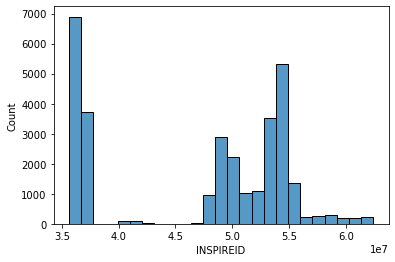

In [69]:
sn.histplot(camden, x = 'INSPIREID')

<AxesSubplot:xlabel='uprn', ylabel='Count'>

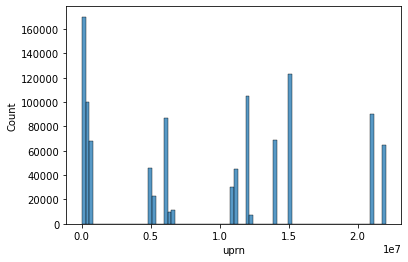

In [52]:
sn.histplot(uprn, x = 'uprn')

In [66]:
uprn.describe()

,uprn,usrn
count,1.048575e+06,1.048575e+06
mean,9.003072e+06,2.448723e+07
std,7.512982e+06,1.552013e+07
min,3.000000e+01,4.400195e+06
25%,5.603180e+05,4.596502e+06
50%,1.100993e+07,2.060219e+07
75%,1.501326e+07,4.470048e+07
max,2.206366e+07,4.809643e+07


In [62]:
camden_merge = pd.merge(camden_price, uprn, how = 'left', left_on = "transactionid", right_on = "transactionid").dropna()
camden_merge[['uprn','usrn']] = camden_merge[['uprn','usrn']].astype(int)

camden_merge['uprn'].head()

0    5129471
1    5112813
2    5112827
3    5112844
4    5112812
Name: uprn, dtype: int64

<AxesSubplot:xlabel='uprn', ylabel='Count'>

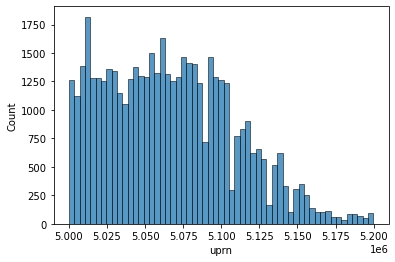

In [63]:
sn.histplot(camden_merge, x = 'uprn')

In [ ]:
camden_merge.plot()

In [49]:
camden_merge = pd.merge(camden_merge, camden, how = 'right', left_on = 'uprn', right_on = 'INSPIREID')
camden_merge['priceper'].info()

<class 'pandas.core.series.Series'>
Int64Index: 30698 entries, 0 to 30697
Series name: priceper
Non-Null Count  Dtype  
--------------  -----  
0 non-null      float64
dtypes: float64(1)
memory usage: 479.7 KB


In [9]:
pricepaid = pd.read_csv("Data/ppdiduprnusrnubdc.csv")
pricepaid.head()

,transactionid,uprn,usrn
0,{DD204FA6-B333-4A06-9E31-7ACABE162EB7},30,4549897
1,{B26F0F8D-4C7A-4DBF-B10A-3336830BF462},31,4549897
2,{241A4A53-DD8C-706B-E050-A8C06205638B},63,4582546
3,{85866A64-627D-143F-E053-6B04A8C06A15},97,4527985
4,{BE61D947-ED06-482E-8274-8B84912C15CB},103,4527985


In [4]:
hh = pd.read_excel("data/tenure - households.xlsx", sheet_name = 3)

In [8]:
hh.head()

,LSOA code,local authority code,local authority name,All Households,Owned outright,Owned with a mortgage or loan,Shared ownership,Rented from Local Authority,Other social rented,Private landlord or letting agency,Other private rented,Rent free
0,E01000001,E09000001,City of London,843,338,144,3,17,4,283,53,1
1,E01000002,E09000001,City of London,825,283,149,2,23,6,324,38,0
2,E01000003,E09000001,City of London,1015,232,145,0,249,52,293,42,2
3,E01000005,E09000001,City of London,482,19,22,1,148,186,91,15,0
4,E01032739,E09000001,City of London,882,118,98,3,3,8,555,97,0


In [7]:
prop = pd.read_excel("data/HPSSA Dataset 46 - Median price paid for residential properties by LSOA.xls", sheet_name = "Data", header = 5)
prop.head()

,Local authority code,Local authority name,LSOA code,LSOA name,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,...,Year ending Sep 2020,Year ending Dec 2020,Year ending Mar 2021,Year ending Jun 2021,Year ending Sep 2021,Year ending Dec 2021,Year ending Mar 2022,Year ending Jun 2022,Year ending Sep 2022,Unnamed: 112
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,34750,34500,30500,30000,29950,29000,...,88000,88000,81500,80500,85500,100750,94000,119000,100000,NaN
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,25000,25000,25300,25625,25000,24800,...,28500,30000,33000,47000,50079,50159,50159,47879,46439.5,NaN
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,27000,27000,27250,28950,28500,28950,...,30000,50000,51500,53000,58573.5,60000,61499.5,61499.5,60000,NaN
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,44500,44500,30000,26675,26000,25500,...,85000,85000,:,83500,83000,80000,76000,75000,75000,NaN
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,22000,27000,27000,20600,20000,19500,...,:,:,:,:,:,90000,:,95000,92500,NaN


In [16]:
prop[['LSOA code','Year ending Sep 2022']].dtypes

LSOA code               object
Year ending Sep 2022    object
dtype: object

In [63]:
hh_prop = pd.merge(hh, prop[['LSOA code','Year ending Sep 2022']], left_on = "LSOA code", right_on ="LSOA code", how = "left")
hh_prop = clean_columns(hh_prop)
hh_prop.head()

13 column names have been cleaned

,lsoa_code,local_authority_code,local_authority_name,all_households,owned_outright,owned_with_a_mortgage_or_loan,shared_ownership,rented_from_local_authority,other_social_rented,private_landlord_or_letting_agency,other_private_rented,rent_free,year_ending_sep_2022
0,E01000001,E09000001,City of London,843,338,144,3,17,4,283,53,1,827500
1,E01000002,E09000001,City of London,825,283,149,2,23,6,324,38,0,815000
2,E01000003,E09000001,City of London,1015,232,145,0,249,52,293,42,2,540000
3,E01000005,E09000001,City of London,482,19,22,1,148,186,91,15,0,:
4,E01032739,E09000001,City of London,882,118,98,3,3,8,555,97,0,645000


In [64]:
hh_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   lsoa_code                           4994 non-null   object
 1   local_authority_code                4994 non-null   object
 2   local_authority_name                4994 non-null   object
 3   all_households                      4994 non-null   int64 
 4   owned_outright                      4994 non-null   int64 
 5   owned_with_a_mortgage_or_loan       4994 non-null   int64 
 6   shared_ownership                    4994 non-null   int64 
 7   rented_from_local_authority         4994 non-null   int64 
 8   other_social_rented                 4994 non-null   int64 
 9   private_landlord_or_letting_agency  4994 non-null   int64 
 10  other_private_rented                4994 non-null   int64 
 11  rent_free                           4994 non-null   int6

In [65]:
hh_prop['year_ending_sep_2022'] = pd.to_numeric(hh_prop['year_ending_sep_2022'],errors = 'coerce')
hh_prop.dropna(inplace=True)
hh_prop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4248 entries, 0 to 4985
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   lsoa_code                           4248 non-null   object 
 1   local_authority_code                4248 non-null   object 
 2   local_authority_name                4248 non-null   object 
 3   all_households                      4248 non-null   int64  
 4   owned_outright                      4248 non-null   int64  
 5   owned_with_a_mortgage_or_loan       4248 non-null   int64  
 6   shared_ownership                    4248 non-null   int64  
 7   rented_from_local_authority         4248 non-null   int64  
 8   other_social_rented                 4248 non-null   int64  
 9   private_landlord_or_letting_agency  4248 non-null   int64  
 10  other_private_rented                4248 non-null   int64  
 11  rent_free                           4248 no

In [66]:
hh_prop.columns

Index(['lsoa_code', 'local_authority_code', 'local_authority_name',
       'all_households', 'owned_outright', 'owned_with_a_mortgage_or_loan',
       'shared_ownership', 'rented_from_local_authority',
       'other_social_rented', 'private_landlord_or_letting_agency',
       'other_private_rented', 'rent_free', 'year_ending_sep_2022'],
      dtype='object')

In [67]:
hh_prop = hh_prop.drop(['lsoa_code', 'local_authority_code'], axis = 1)

In [68]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(hh_prop.drop(['year_ending_sep_2022'], axis = 1), hh_prop.year_ending_sep_2022, random_state=random_state_split)

In [70]:
hh_prop.columns

Index(['local_authority_name', 'all_households', 'owned_outright',
       'owned_with_a_mortgage_or_loan', 'shared_ownership',
       'rented_from_local_authority', 'other_social_rented',
       'private_landlord_or_letting_agency', 'other_private_rented',
       'rent_free', 'year_ending_sep_2022'],
      dtype='object')

In [69]:
# The missing values of a numeric feature will be replaced by the 'mean' value of the feature.
# The missing values of a categorical feature will be replaced by the a 'constant' value. If 'constant' value is not specified, it is default at '0' for numerical data or 'np.nan' for categorical data.

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OneHotEncoder(drop='first'))
])

In [71]:
numeric_features = ['all_households', 'owned_outright',
       'owned_with_a_mortgage_or_loan', 'shared_ownership',
       'rented_from_local_authority', 'other_social_rented',
       'private_landlord_or_letting_agency', 'other_private_rented',
       'rent_free']
categorical_features = ['local_authority_name']
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
])

In [72]:
pipeline = Pipeline(steps = [
   ('preprocessor', preprocessor),
   ('regressor',DecisionTreeRegressor())
])

In [73]:
cart_model = pipeline.fit(train_x, train_y)
# this will visualise the pipeline
print(cart_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['all_households',
                                                   'owned_outright',
                                                   'owned_with_a_mortgage_or_loan',
                                                   'shared_ownership',
                                                   'rented_from_local_authority',
                                                   'other_social_rented',
                                                   'private_landlord_or_letting_agency',
                                        

In [74]:
print("RMSE on the training data:")
print(mean_squared_error(train_y, cart_model.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, cart_model.predict(test_x), squared=False))

RMSE on the training data:
0.0
RMSE on the testing data:
375204.5288037771


In [75]:
print("R2 on the training data:")
print(r2_score(train_y, cart_model.predict(train_x)))
print("R2 on the testing data:")
print(r2_score(test_y, cart_model.predict(test_x)))

R2 on the training data:
1.0
R2 on the testing data:
0.21370862745903274


In [76]:
# we fix the random_state in DecisionTreeRegressor() so that the result of GridSearchCV is the same in different runs
cart_pipeline = Pipeline(steps = [
  ('preprocessor', preprocessor),
  ('regressor', DecisionTreeRegressor(random_state=123))
])

cart_pipeline.fit(train_x, train_y)
# in order to change the model, needs to be changed in cart_pipeline and grid_params
# grid_params is the range of each hyperparameter
grid_params = {
  'regressor__max_depth': [10,20,30,40,50], 
  'regressor__min_samples_split': [2,4,6,8,10]
}
search = GridSearchCV(cart_pipeline, grid_params)
search.fit(train_x, train_y)
print("Best R2 Score: ", search.best_score_)
print("Best Params: ", search.best_params_)

Best R2 Score:  0.1981665656064094
Best Params:  {'regressor__max_depth': 10, 'regressor__min_samples_split': 10}


In [77]:
regressors = {
    'Linear': LinearRegression(),
    'CART': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'XGB': XGBRegressor()
}

# a dict to store the R2 of training and testing data
dict_results = dict()

for name, regressor in regressors.items():
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', regressor)
           ])
    model = pipeline.fit(train_x, train_y)
    predictions = model.predict(test_x)
    dict_results[name] = [model.score(train_x, train_y), model.score(test_x, test_y), model.score(train_x, train_y) - model.score(test_x, test_y)]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
df_models

,R2_train_data,R2_test_data,R2_diff
Linear,0.430968,0.480808,-0.049841
CART,1.000000,0.283514,0.716486
RF,0.923672,0.584722,0.338950
XGB,0.972459,0.549990,0.422469


Methodology 

Results 

Discussion 

Conclusion 